In [14]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import csv
!pip install evaluate
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline
import torch

# model_name = "distilbert-base-uncased-finetuned-sst-2-english"
# model = DistilBertForSequenceClassification.from_pretrained(model_name)
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [15]:
import pandas as pd
from nltk.corpus import stopwords, words as nltk_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
from wordcloud import STOPWORDS as wordcloud_stopwords
import string

# Function to load data from a CSV file
def load_data(file_name):
    """
    Read the CSV file into a Pandas DataFrame

    Args:
        file_name (str): Name of the CSV file.

    Returns:
        pandas.DataFrame: DataFrame containing the CSV data.
    """
    return pd.read_csv(file_name, encoding='latin1')

# Function to preprocess text data
def preprocess_text(df):
    """
    Filter out rows with no text in the "RESPONSE_TEXT" column or NaN values (i.e., no course review).

    Args:
        df (pandas.DataFrame): Input DataFrame.

    Returns:
        pandas.DataFrame: DataFrame with filtered data.
    """
    # Filter out rows with no text in the "RESPONSE_TEXT" column or NaN values (i.e., no course review).
    filtered_rows = df[df['RESPONSE_TEXT'].str.strip().str.len() > 0 & pd.notna(df['RESPONSE_TEXT'])]
    return filtered_rows

# Function to filter rows for a specific course
def filter_course_rows(dataframe, course_name):
    """
    Filter rows in the DataFrame for a specific course.

    Args:
        dataframe (pandas.DataFrame): Input DataFrame.
        course_name (str): Name of the course to filter.

    Returns:
        pandas.DataFrame: Filtered DataFrame for the specified course.
    """
    course_rows = dataframe[dataframe['COURSE_UNIQUE_ID'].str.contains(course_name)]
    reviews_list = course_rows["RESPONSE_TEXT"].tolist()
    return reviews_list

# Function to remove stopwords and punctuation from a list of words
def remove_stopwords(word_list):
    # Load NLTK stopwords, English words, and punctuation
    stop_words = set(stopwords.words('english'))
    stop_words.update(nltk_words.words())
    stop_words.update(ENGLISH_STOP_WORDS)
    stop_words.update(gensim_stopwords)
    stop_words.update(wordcloud_stopwords)
    stop_words.update(string.punctuation)

    # Add a custom list to the stopwords
    custom_words = ["class", "course", "cs", "professor"]
    stop_words.update(custom_words)

    # Remove stopwords and punctuation
    filtered_words = [word for word in word_list if word.lower() not in stop_words]

    return filtered_words

In [16]:
%cd sample_data


[Errno 2] No such file or directory: 'sample_data'
/content/sample_data


In [17]:
def convert_to_hugging_face_dataset(tsv_path):
    messages = []
    labels = []
    courses = []

    with open(tsv_path, 'r', newline='', encoding='utf8') as tsv_file:
        reader = csv.reader(tsv_file, delimiter='\t')

        for label, message, course in reader:
            messages.append(message)
            labels.append(int(label))  # Convert label to integer
            courses.append(course)

    dataset = Dataset.from_dict({"label": labels, "text": messages, "course": courses})
    return dataset


In [18]:
train_data = convert_to_hugging_face_dataset('train_data_course.tsv')
test_data = convert_to_hugging_face_dataset('test_data_course.tsv')

In [19]:
train_data

Dataset({
    features: ['label', 'text', 'course'],
    num_rows: 1322
})

In [20]:
train_data[:3]

{'label': [0, 0, 0],
 'text': ["TAKE THIS COURSE!! No matter what major you are, it's an extremely insightful and fun course! The structure of the course and the way it's taught is extremely effective. As someone who had never considered computer science in college, I'm not considering a major in computer science and taking more computer science courses at Stanford in the future.",
  "It's a great course!",
  'Take it! The teaching team do a great job of introducing computer science principles to the students, and the course is definitely friendly to people with no coding experience.'],
 'course': ['CS-106A', 'CS-106A', 'CS-106A']}

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

In [ ]:
tokenized_test

In [ ]:
# get sentiment scores for each review

In [43]:
def get_sentiment_score(review):
    specific_model = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")
    sentiment_result = specific_model(review_text)
    print(sentiment_result)
    # Convert 'POSITIVE'/'NEGATIVE' to a numerical score if needed
    score = sentiment_result[0]['score']
    return score if sentiment_result[0]['label'] == 'POSITIVE' else -score

course_sentiment_scores = {}  # Dictionary to hold course-wise aggregated scores
course_review_counts = {}     # Dictionary to count the number of reviews per course
sentiment_scores_per_review = []

# Iterate over each row in the tokenized_test Dataset
for row in tokenized_test:
    review_text = row["text"]
    course = row["course"]
    sentiment_score = get_sentiment_score(review_text)
    sentiment_scores_per_review.append(sentiment_score)
    # print(sentiment_score, review_text)


    # Aggregate sentiment scores and count reviews per course
    if course not in course_sentiment_scores:
        course_sentiment_scores[course] = 0
        course_review_counts[course] = 0
    course_sentiment_scores[course] += sentiment_score
    course_review_counts[course] += 1

    # Append sentiment score to the row (optional if you want to modify the dataset)
    row["sentiment_score"] = sentiment_score

# Calculate the average sentiment score for each course
for course in course_sentiment_scores:
    course_sentiment_scores[course] /= course_review_counts[course]

# Now course_sentiment_scores has the average sentiment score for each course

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9992744326591492}]
[{'label': 'POSITIVE', 'score': 0.993131697177887}]
[{'label': 'POSITIVE', 'score': 0.9996838569641113}]
[{'label': 'POSITIVE', 'score': 0.9948264956474304}]
[{'label': 'POSITIVE', 'score': 0.997572124004364}]
[{'label': 'POSITIVE', 'score': 0.9982399940490723}]
[{'label': 'POSITIVE', 'score': 0.9991378784179688}]
[{'label': 'POSITIVE', 'score': 0.9998581409454346}]
[{'label': 'POSITIVE', 'score': 0.9480603933334351}]
[{'label': 'NEGATIVE', 'score': 0.9995653033256531}]
[{'label': 'NEGATIVE', 'score': 0.9688385128974915}]
[{'label': 'POSITIVE', 'score': 0.9998819828033447}]
[{'label': 'POSITIVE', 'score': 0.9998162388801575}]
[{'label': 'POSITIVE', 'score': 0.9998798370361328}]
[{'label': 'POSITIVE', 'score': 0.9998410940170288}]
[{'label': 'POSITIVE', 'score': 0.997373104095459}]
[{'label': 'POSITIVE', 'score': 0.9997205138206482}]
[{'label': 'NEGATIVE', 'score': 0.9531005620956421}]
[{'label': 'POSITIVE', 'score': 0.999635577201843

In [27]:
tokenized_test

Dataset({
    features: ['label', 'text', 'course', 'input_ids', 'attention_mask'],
    num_rows: 333
})

In [28]:
# get overall sentiment score for each course
# course_sentiment_scores

In [29]:
!pip install -U scikit-learn

In [30]:
!pip install -U matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [31]:
# import numpy as np
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# def perform_clustering(sentiment_scores, n_clusters):
#     # Create an array for the sentiment scores
#     Y = np.array(list(sentiment_scores.values())).reshape(-1, 1)
#     # Create a dummy array to spread the courses evenly on the x-axis
#     X = np.arange(len(sentiment_scores)).reshape(-1, 1)
#     # Combine the dummy X and the sentiment Y for clustering
#     XY = np.hstack((X, Y))
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#     kmeans.fit(XY)
#     return kmeans.labels_, XY

# def visualize_clusters(XY, course_ids, cluster_labels, n_clusters):
#     plt.figure(figsize=(10, 8))
#     for cluster_label in range(n_clusters):
#         # Get the indexes of points for each cluster
#         idxs = np.where(cluster_labels == cluster_label)[0]
#         plt.scatter(XY[idxs, 0], XY[idxs, 1], label=f'Cluster {cluster_label}', alpha=0.7)
#         for i in idxs:
#             plt.annotate(course_ids[i], (XY[i, 0], XY[i, 1]))

#     plt.title('Course Clustering Results')
#     plt.xlabel('Courses')
#     plt.ylabel('Sentiment Score')
#     plt.xticks(ticks=XY[:, 0], labels=course_ids, rotation=90)  # Set x-ticks to be the course names
#     plt.legend()
#     plt.show()

# def main(course_sentiment_scores):
#     course_ids = list(course_sentiment_scores.keys())
#     n_clusters = 3  # Number of clusters (easy, medium, hard)
#     cluster_labels, XY = perform_clustering(course_sentiment_scores, n_clusters)
#     visualize_clusters(XY, course_ids, cluster_labels, n_clusters)

# if __name__ == "__main__":
#     course_sentiment_scores = {
#         'CS-106A': 0.7436882853507996,
#         'CS-106B': 0.5175019922581586,
#         'CS-107': 0.6193486154079437,
#         'CS-109': 0.8276243339414182,
#         'CS-103': 0.7224952415986494,
#         'CS-161': -0.016590225425633518,
#         'MATH-51': 0.26049033233097624
#     }
#     main(course_sentiment_scores)


In [41]:
# then classify into labels
from sklearn.metrics import mean_squared_error

course_sentiment_scores = {
  'CS-106A': 0.7436882853507996,
  'CS-106B': 0.5175019922581586,
  'CS-107': 0.6193486154079437,
  'CS-109': 0.8276243339414182,
  'CS-103': 0.7224952415986494,
  'CS-161': -0.016590225425633518,
  'MATH-51': 0.26049033233097624
}

actual_labels = {"CS-106A" : 0, "CS-106B" : 1, "CS-107" : 2, "CS-109" : 2, "CS-103" : 1, "CS-161" : 2, "MATH-51" : 2}

def assign_label(sentiment_score, cutoffs):
    """
    Assign a label to a course based on its sentiment score and cutoff points.

    Parameters:
    sentiment_score (float): The average sentiment score of a course.
    cutoffs (tuple): A tuple of two floats representing the cutoff points for labeling.

    Returns:
    int: The label for the course (0 for 'easy', 1 for 'medium', 2 for 'hard').
    """
    if sentiment_score >= cutoffs[1]:
        return 0  # Easy
    elif sentiment_score >= cutoffs[0]:
        return 1  # Medium
    else:
        return 2  # Hard

# Function to calculate mean squared error loss given cutoffs
def calculate_loss(cutoffs, actual_labels, course_sentiment_scores):
    predicted_labels = {course: assign_label(score, cutoffs) for course, score in course_sentiment_scores.items()}
    # Calculate MSE loss
    mse_loss = mean_squared_error(list(actual_labels.values()), list(predicted_labels.values()))
    return mse_loss

# Initial heuristic cutoffs
cutoff_1 = np.percentile(list(course_sentiment_scores.values()), 33)
cutoff_2 = np.percentile(list(course_sentiment_scores.values()), 66)
print(cutoff_1, cutoff_2)

# Optimization loop - this is a very simplistic approach and could be replaced with a more sophisticated method
best_loss = float('inf')
best_cutoffs = (cutoff_1, cutoff_2)
for cutoff_1 in np.linspace(-1, 1, 20):  # Assuming sentiment scores range from -1 to 1
    for cutoff_2 in np.linspace(cutoff_1, 1, 20):
        loss = calculate_loss((cutoff_1, cutoff_2), actual_labels, course_sentiment_scores)
        if loss < best_loss:
            best_loss = loss
            best_cutoffs = (cutoff_1, cutoff_2)

print(f"Best cutoffs: {best_cutoffs} with loss: {best_loss}")



# train_data[0]
# {'label': 0,
#  'text': "TAKE THIS COURSE!! No matter what major you are, it's an extremely insightful and fun course! The structure of the course and the way it's taught is extremely effective. As someone who had never considered computer science in college, I'm not considering a major in computer science and taking more computer science courses at Stanford in the future.",
#  'course': 'CS-106A'}





0.512361759059615 0.7183693765510212
Best cutoffs: (0.26315789473684204, 0.8448753462603878) with loss: 0.42857142857142855


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


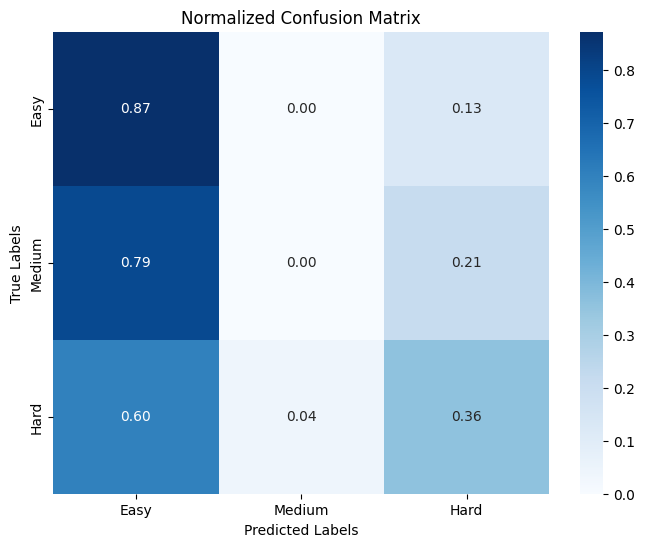

0.36036036036036034


In [48]:
cutoffs = (0.26315789473684204, 0.8448753462603878)

def assign_label(score):
    if score >= cutoffs[1]:
        return 0  # Easy
    elif score >= cutoffs[0]:
        return 1  # Medium
    else:
        return 2  # Hard


import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create and display a normalized confusion matrix
def create_normalized_confusion_matrix(true_labels, predicted_labels, classes, output_filepath=None):
    """
    Plot a confusion matrix.
    Args:
        true_labels: True class labels
        predicted_labels: Predicted class labels
        classes: List of class labels
    """
    cm = confusion_matrix(true_labels, predicted_labels)

    # Normalize the values
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Normalized Confusion Matrix")

    if output_filepath:
        plt.savefig(output_filepath, bbox_inches='tight')
    else:
        plt.show()

# Collect true labels and predicted labels
true_labels = [row["label"] for row in tokenized_test]
predicted_labels = [assign_label(score) for score in sentiment_scores_per_review]
print(true_labels)
print(predicted_labels)

# Assuming these are your class labels
classes = ['Easy', 'Medium', 'Hard']

# Generate and display the confusion matrix
create_normalized_confusion_matrix(true_labels, predicted_labels, classes)


matching_elements_count = sum([a == b for a, b in zip(true_labels, predicted_labels)])
accuracy = matching_elements_count / len(true_labels)
print(accuracy)

# # Iterate over each row in the tokenized_test Dataset
# for i in range(len(tokenized_test)):
#   true_label = row["label"]
#   predicted_label = assign_label(sentiment_scores_per_review[i])


